<p style="font-size:32px; font-weight: bolder; text-align: center"> Supervised and unsupervised learning for atomic-scale modeling </p>
<p style="text-align: center"><i> authored by: <a href="mailto:michele.ceriotti@gmail.com"> Michele Ceriotti </a></i></p>

This notebook provides a hands-on complement to the first lecture in the "Introduction to Atomic-Scale Machine Learning" mini-course. It provides an overview of the practical calculation of representations for atomic environments and structures, as well as of simple linear and kernel algorithms for unsupervised and supervised learning. 

The notebook contains two examples:

1. [Molecular motif recognition: detection of solid nuclei in supercooled irons](#iron-motifs)
2. [Linear methods: structure-property maps for azaphenacene](#azaphenacene)

In [1]:
%matplotlib inline
import numpy as np
import ase, ase.io
import matplotlib as mpl
import matplotlib.pyplot as plt 
import itertools

import chemiscope

import rascaline
from metatensor import mean_over_samples, Labels

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV

<a id="iron-motifs"> </a>

# Molecular motif recognition: detection of solid nuclei in supercooled iron

This example takes a structure which is cut ouf of a simulation of freezing iron ([Shibuta et al., Acta Mater. (2016)](https://www.sciencedirect.com/science/article/abs/pii/S1359645415301397)).
The snapshot contains a few solid nuclei embedded in a supercoled liquid.

We will use atom-centered descriptors and principal component analysis to color atoms based on whether they are in liquid or solid regions. 

## Loads and visualizes the structure

In [2]:
frame_iron = ase.io.read("data/iron-snapshot.xyz", 0)

In [3]:
# requires running in a jupyter notebook, and takes a while to load - it's > 100k atoms!
cs = chemiscope.show(frames=[frame_iron], mode="structure", 
                     settings={"structure": [ {"bonds": False, "unitCell": True} ] })

if chemiscope.jupyter._is_running_in_notebook():
    from IPython.display import display
    display(cs)

<StructureWidget(meta={'name': ' '}, settings={'structure': [{'bonds': False, 'unitCell': True}]}, structures=…

## Feature evaluation 

Computes SOAP descriptors ([Bartók et al., PRB (2013)](https://doi.org/10.1103/PhysRevB.87.184115)) using a smooth Laplacian Eigenvalues radial basis ([Bigi et al., JCP (2022)](https://doi.org/10.1063/5.0124363)). The parameters are quite coarse, as we only want to detect order/disorder in the neighborhood of each atom.  

In [4]:
hypers = {
    "cutoff": 4,
    "max_radial": 4,
    "max_angular": 2,
    "atomic_gaussian_width": 0.5,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "center_atom_weight": 1.0
}

basis = rascaline.utils.SoapSpliner(
    cutoff=hypers["cutoff"],
    max_radial=hypers["max_radial"],
    max_angular=hypers["max_angular"],
    basis=rascaline.utils.SphericalBesselBasis(hypers["cutoff"], hypers["max_radial"], hypers["max_angular"]),
    density=rascaline.utils.GaussianDensity(atomic_gaussian_width=hypers["atomic_gaussian_width"])
).compute()

hypers["radial_basis"] = basis

In [5]:
calculator = rascaline.SoapPowerSpectrum(**hypers)

We ignore the atoms at the border because the structure is cut out of a very large box so the atoms at the surface have a very different (unphysical) environment.

In [6]:
selection = np.where((frame_iron.positions[:,0]>hypers["cutoff"]+1) & (frame_iron.positions[:,0]<199-hypers["cutoff"]) &
                     (frame_iron.positions[:,1]>hypers["cutoff"]+1) & (frame_iron.positions[:,1]<199-hypers["cutoff"]) )[0] 

In [7]:
rho2i = calculator.compute(frame_iron, 
                           selected_samples=Labels(names="center", values=selection.reshape(-1,1))
                          )

The features are stored in a block-sparse format (a TensorMap from the [metatensor](https://lab-cosmo.github.io/metatensor/) package). For SOAP features, blocks correspond to correlation between different atom types. In this case there is only one block, because all atoms are Fe. 

Each block contains a dense array of features, and it's associated with metadata that describe what they correspond to - in this case one row per atomic environment, a single component because it contains scalar features, and labels that describe how each feature is computed. 

In [8]:
rho2i

TensorMap with 1 blocks
keys: species_center  species_neighbor_1  species_neighbor_2
            26                26                  26

In [9]:
rho2i.block(0)

TensorBlock
    samples (132309): ['structure', 'center']
    components (): []
    properties (48): ['l', 'n1', 'n2']
    gradients: None

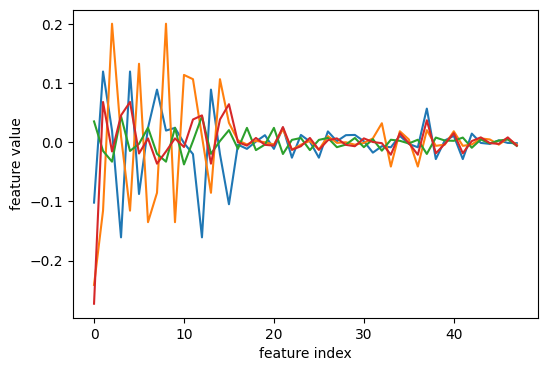

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
y = rho2i.block(0).values - rho2i.block(0).values.mean(axis=0)
ax.plot(y[0])
ax.plot(y[10])
ax.plot(y[100])
ax.plot(y[1000])
ax.set_xlabel('feature index')
ax.set_ylabel('feature value');

## Visualize the environments with a PCA map

We now run a simple PCA analysis to identify motifs in the data. One can see the shape of the nuclei...

In [11]:
iron_pca = PCA(n_components=4)
pca_features = iron_pca.fit_transform(rho2i.block(0).values[:,:])
iron_pca.singular_values_

array([222.82354291, 168.80144655,  84.23053655,  15.57107601])

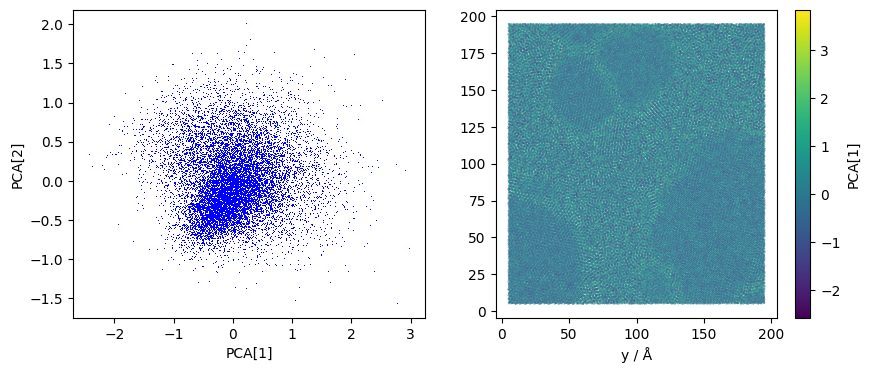

In [12]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(pca_features[::10,0], pca_features[::10,1], 'b,')
ax[0].set_xlabel("PCA[1]")
ax[0].set_ylabel("PCA[2]")
scatter = ax[1].scatter(frame_iron.positions[selection,0],
            frame_iron.positions[selection,1],
            c=pca_features[:,0], marker='.', s=0.1)
ax[1].set_xlabel("x / Å")
ax[1].set_xlabel("y / Å")
fig.colorbar(scatter, label="PCA[1]");

... but there is too much thermal noise! 
A solution would be to compute locally-averaged descriptors, but alternatively we can use the fact that we expect fcc orientational order to have zero components along $l=1$ and $l=2$ O(3) irreps, and to have a clearer signal than what can be inferred from the totally symmetric features that only pick up density fluctuations

In [13]:
iron_pca = PCA(n_components=4)
pca_features = iron_pca.fit_transform(
                    rho2i.block(0).values[:, np.where(rho2i.block(0).properties["l"]>0)[0]]
                )
iron_pca.singular_values_

array([16.12255848, 15.02794107,  8.70194317,  8.21433877])

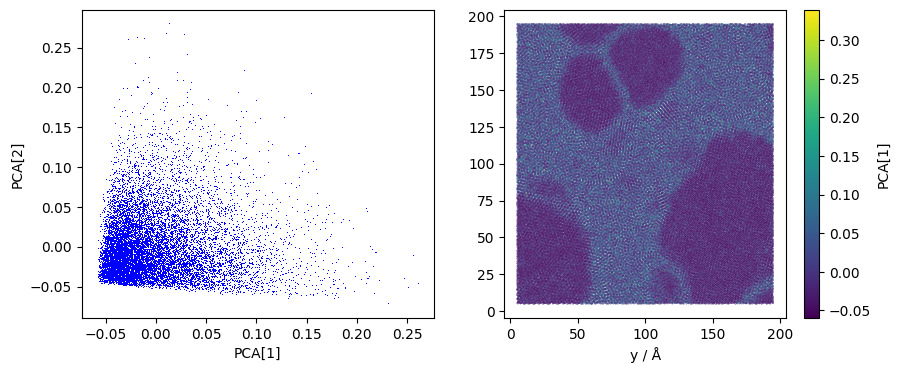

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(pca_features[::10,0], pca_features[::10,1], 'b,')
ax[0].set_xlabel("PCA[1]")
ax[0].set_ylabel("PCA[2]")
scatter = ax[1].scatter(frame_iron.positions[selection,0],
            frame_iron.positions[selection,1],
            c=pca_features[:,0], marker='.', s=0.1)
ax[1].set_xlabel("x / Å")
ax[1].set_xlabel("y / Å")
fig.colorbar(scatter, label="PCA[1]");

Interactive viewer

In [15]:
cs = chemiscope.show(frames = [frame_iron], 
                     properties = { 'PCA' : pca_features },
                     environments = [[0,s,5] for s in selection],
                     settings={"structure": [ {"bonds": False, "unitCell": True, 
                                           'environments': {'activated': False},
                                           'color': {'property': 'PCA[1]', 'palette': 'viridis', 'min': -0.05, 'max': 0.05 } 
                                              } ] },
                    mode="structure",                     
                    )

if chemiscope.jupyter._is_running_in_notebook():
    from IPython.display import display
    display(cs)

<StructureWidget(meta={'name': ' '}, settings={'structure': [{'bonds': False, 'unitCell': True, 'environments'…

<a id="azaphenacene"> </a>

# A structure-property map for azaphenacene organic conductors 

This examples uses a small dataset of 156 molecular crystals ([Yang et al., Chem. Mater. (2018)](http://doi.org/10.1021/acs.chemmater.8b01621)), assembled from 28 different structural isomers of azaphenacene derivatives. Lattice energy and electronic mobility have been computed for each structure, as well as a heuristic classification of the packing motif and an estimate of the mean number of hydrogen bonds per molecule.

We use this dataset as an example of the construction of structure-property maps for structures, rather than for atomic environments, and to demonstrate several linear methods for data analytics

In [20]:
# A bunch of utility functions for the visualization
# ==================================================

# Custom color map
c1, c2 = mpl.colors.to_rgb("#a02c2cff"), mpl.colors.to_rgb("#2c5aa0ff")
ccrmap = mpl.colors.LinearSegmentedColormap.from_list('chemrev', [(0, [0.13605392, 0.39040103, 0.77745098]), 
                                                                  (0.5,[0.565     , 0.39638094, 0.565     ]), 
                                                                  (1,[0.9754902 , 0.77042872, 0.77042872])])

# A helper function to plot the structures with markers based on HB counts
def hb_color_plot(ax, XY, Z, hbs):
    vmi, vma = Z.min(), Z.max()
    ax.scatter(XY[hbs==0,0], XY[hbs==0,1],  c=Z[hbs==0], vmin=vmi, vmax=vma, cmap=ccrmap, marker='x')
    ax.scatter(XY[hbs==1,0], XY[hbs==1,1],  c=Z[hbs==1], vmin=vmi, vmax=vma, cmap=ccrmap, marker='.')
    sct = ax.scatter(XY[hbs==2,0], XY[hbs==2,1],  c=Z[hbs==2], vmin=vmi, vmax=vma, cmap=ccrmap, marker='*')
    return sct

## Loads and visualizes the structures in the dataset

Familiarize yourself with the dataset

In [21]:
aza_frames = ase.io.read("data/azaphenacene.xyz", ":")

properties = {
 prop: np.array([f.info[prop] for f in aza_frames])
 for prop in ["energy", "mobility", "nHB"]}

In [22]:
cs = chemiscope.show(frames = aza_frames,
                properties = chemiscope.extract_properties(aza_frames),
              settings =  {'map': {'x': {'property': 'mobility','scale': 'log'},
                                   'y': {'property': 'energy','scale': 'linear'},
                                   'symbol': 'nHB_class',
                                   'palette': 'inferno',
                                    'color': {'property': 'molecule'},
                                  },
                             'structure': [{'unitCell': True,
                                            'supercell': {'0': 2, '1': 2, '2': 2},
                                           }]
                          },
               mode="default")
if chemiscope.jupyter._is_running_in_notebook():
    from IPython.display import display
    display(cs)

<ChemiscopeWidget(meta={'name': ' '}, settings={'map': {'x': {'property': 'mobility', 'scale': 'log'}, 'y': {'…

In [23]:
cs.selection = {'environment': 10, 'structure': 10}

## Evaluate features

Computes SOAP descriptors ([Bartók et al., PRB (2013)](https://doi.org/10.1103/PhysRevB.87.184115)) using a smooth Laplacian Eigenvalues radial basis ([Bigi et al., JCP (2022)](https://doi.org/10.1063/5.0124363)). We only compute features that are centered on [C,N,O] atoms, and average over the atoms in each structure to obtain structure-based features,

$$
|A\rangle = \sum_i |A_i\rangle
$$

In [24]:
hypers = {
    "cutoff": 5,
    "max_radial": 4,
    "max_angular": 2,
    "atomic_gaussian_width": 0.5,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "center_atom_weight": 1.0
}

basis = rascaline.utils.SoapSpliner(
    cutoff=hypers["cutoff"],
    max_radial=hypers["max_radial"],
    max_angular=hypers["max_angular"],
    basis=rascaline.utils.SphericalBesselBasis(hypers["cutoff"], hypers["max_radial"], hypers["max_angular"]),
    density=rascaline.utils.GaussianDensity(atomic_gaussian_width=0.5)
).compute()

hypers["radial_basis"] = basis

In [25]:
calculator = rascaline.SoapPowerSpectrum(**hypers)

In [26]:
selected_keys = np.array(list(itertools.product([6,7,8],[1,6,7,8],[1,6,7,8])))

In [27]:
rho2i = calculator.compute(aza_frames,                            
                           selected_keys=Labels(names=["species_center", "species_neighbor_1", "species_neighbor_2"],
                                                values=selected_keys)
                          )

Now the TensorMap contains separate blocks for the different centers, and the types of neighbors. This is useful e.g. to then select only some blocks, or in cases in which some of the structures don't contain all types of atoms. 

In [31]:
rho2i.block(0)

TensorBlock
    samples (9824): ['structure', 'center']
    components (): []
    properties (48): ['l', 'n1', 'n2']
    gradients: None

In this case, we will just consolidate this into a structure-based descriptor. We use some `metatensor` utilities to manipulate keys and to sum over sample labels we want to average out. 

In [32]:
rhoi = mean_over_samples(rho2i.keys_to_properties(["species_neighbor_1","species_neighbor_2"]).keys_to_samples(["species_center"]), sample_names = ["center", "species_center"])

In [33]:
rhoi.block(0)

TensorBlock
    samples (156): ['structure']
    components (): []
    properties (768): ['species_neighbor_1', 'species_neighbor_2', 'l', 'n1', 'n2']
    gradients: None

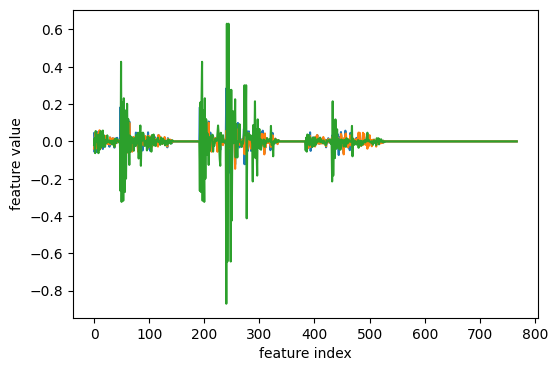

In [34]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
y = rhoi.block(0).values - rhoi.block(0).values.mean(axis=0)
ax.plot(y[0])
ax.plot(y[10])
ax.plot(y[100])
ax.set_xlabel('feature index')
ax.set_ylabel('feature value');

## Visualize the structures with a PCA map

We compute a simple PCA on the structure features. 

In [35]:
aza_pca = PCA(n_components=4)
pca_features = aza_pca.fit_transform(rhoi.block(0).values[:,:])
aza_pca.singular_values_

array([10.72974528,  6.10591634,  3.9693465 ,  3.43677111])

The top PCA features are not particularly effective at identifying structure-property relations

Text(0, 0.5, 'PCA[2]')

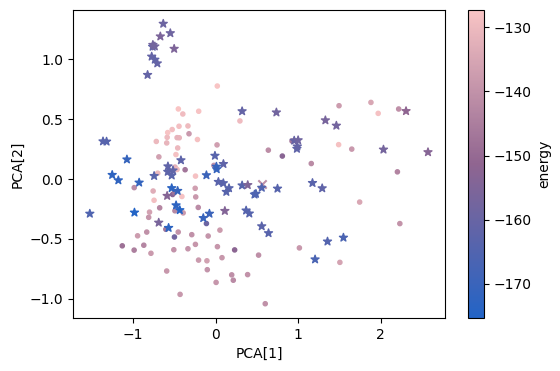

In [36]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
hb_color_plot(ax, pca_features[:,[0,1]], properties["energy"], properties["nHB"])
fig.colorbar(ax.collections[-1], label="energy")
ax.set_xlabel("PCA[1]")
ax.set_ylabel("PCA[2]")

## Ridge regression

`RidgeCV` evaluates by n-fold cross-validation the best regularizer for a ridge regression exercise. It is usually a good idea to span a broad range of values. 

In [37]:
ridge = RidgeCV(alphas=np.geomspace(1e-6, 1e0, 16), store_cv_values=True)

In [38]:
X = rhoi.block(0).values
y = properties["energy"]

In [39]:
ridge.fit(X[::2], y[::2])

RidgeCV(alphas=array([1.00000000e-06, 2.51188643e-06, 6.30957344e-06, 1.58489319e-05,
       3.98107171e-05, 1.00000000e-04, 2.51188643e-04, 6.30957344e-04,
       1.58489319e-03, 3.98107171e-03, 1.00000000e-02, 2.51188643e-02,
       6.30957344e-02, 1.58489319e-01, 3.98107171e-01, 1.00000000e+00]),
        store_cv_values=True)

You can visualize the cross-validation error as a function of the ridge regularization, which highlights the importance of choosing a good regularizer to avoid over and under-fitting

Text(0, 0.5, 'RMSE$_\\mathrm{CV}$')

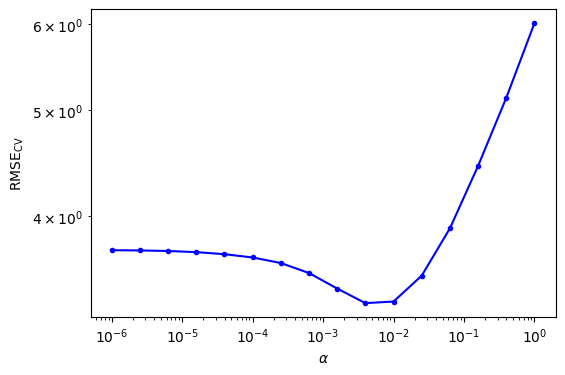

In [40]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.loglog(ridge.alphas, np.sqrt(ridge.cv_values_.mean(axis=0)), 'b.-')
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"RMSE$_\mathrm{CV}$")

Even with a ridge regularization, there is clear overfitting - the train error is 

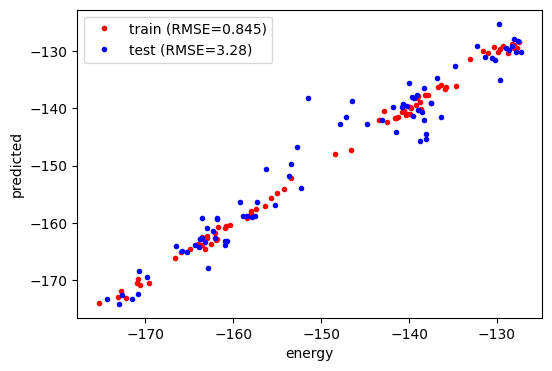

In [41]:
y_pred = ridge.predict(X)
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(y[::2], y_pred[::2], 'r.', label=f"train (RMSE={np.sqrt(np.mean((y[::2]-y_pred[::2])**2)):.3})")
ax.plot(y[1::2], y_pred[1::2], 'b.', label=f"test (RMSE={np.sqrt(np.mean((y[1::2]-y_pred[1::2])**2)):.3})")
ax.set_xlabel(r"energy")
ax.set_ylabel(r"predicted")
ax.legend();

### Learning curves

Learning curves provide an indication of whether the accuracy of the model is limited by the complexity of the model or the amount of training data. We use `ShuffleSplit` to test the accuracy on multiple random train/test splits.

In [42]:
from sklearn.model_selection import learning_curve, ShuffleSplit

In [43]:
# Define the training set sizes
train_sizes = np.geomspace(0.05, 1.0, 8) 

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# Compute the learning curves with a given model, inputs, and outputs
train_sizes, train_scores, validation_scores = learning_curve(
    ridge, X, y, train_sizes=train_sizes, cv=cv, scoring='neg_mean_squared_error'
)

# Calculate the mean and standard deviation of the training and validation scores
validation_scores_mean = np.sqrt(-validation_scores).mean(axis=1)
validation_scores_std = np.sqrt(-validation_scores).std(axis=1)

The learning curve shows that (unsurprisingly) the accuracy of the model is data-limited.

Text(0, 0.5, 'RMSE$_\\mathrm{CV}$')

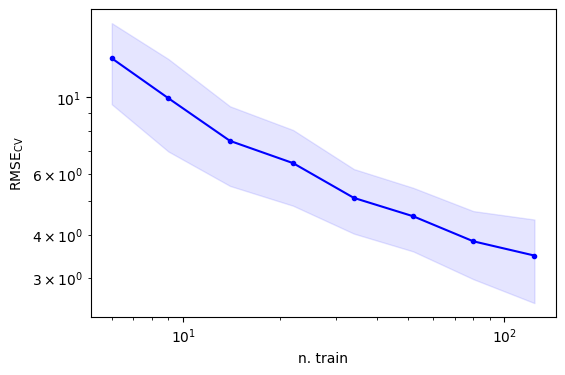

In [44]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.loglog(train_sizes, validation_scores_mean, 'b.-')
ax.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color='b')
ax.set_xlabel(r"n. train")
ax.set_ylabel(r"RMSE$_\mathrm{CV}$")

## Visualize the Principal Covariates Regression map

PCOvR looks for a low-dimensional projection that captures a large fraction of the variance of the dataset, but at the same time can predict well a target quantity

In [45]:
from skmatter.decomposition import PCovR

In [46]:
aza_pcovr = PCovR(n_components=2, mixing=0.5)
pcovr_features = aza_pcovr.fit_transform(rhoi.block(0).values[:,:], 
                                        properties["energy"])

/home/michele/local/lib/python3.8/site-packages/skmatter/decomposition/_pcovr.py:264: UserWarning: This class does not automatically center data, and your data mean is greater than the supplied tolerance.
  warnings.warn(


PCOvR coordinates are better than PCA at capturing the structure-property relation that is explicitly required (which is trivial, as long as the target property can be linearly regressed well) and also correlate better with "traditional" indicators such as the number of hydrogen-bonds per molecule

Text(0, 0.5, 'PCovR[2]')

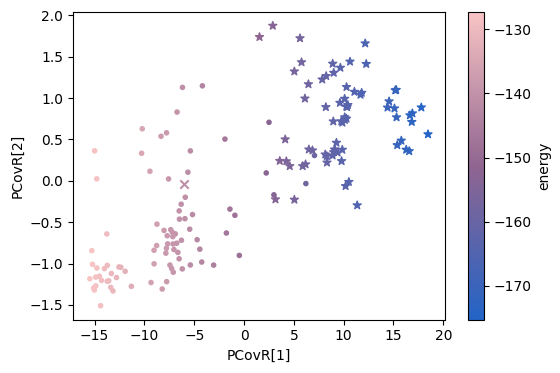

In [47]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
hb_color_plot(ax, pcovr_features[:,[0,1]], properties["energy"], properties["nHB"])
fig.colorbar(ax.collections[-1], label="energy")
ax.set_xlabel("PCovR[1]")
ax.set_ylabel("PCovR[2]")

## Overall visualization of the results

You can use this interactive visualizer to re-cap the results of the various methods

In [48]:
aza_properties = chemiscope.extract_properties(aza_frames)
aza_properties.update({
                    "PCA" : pca_features,
                    "PCovR" : pcovr_features,
                    "energy_predicted": y_pred,
                    "energy_error": y_pred-y
                    })

In [49]:
cs = chemiscope.show(frames = aza_frames,
                properties = aza_properties,
              settings =  {'map': {'x': {'property': 'PCovR[1]','scale': 'linear'},
                                   'y': {'property': 'PCovR[2]','scale': 'linear'},
                                   'symbol': 'nHB_class',
                                   'palette': 'inferno',
                                    'color': {'property': 'energy'},
                                  },
                             'structure': [{'unitCell': True,
                                            'supercell': {'0': 2, '1': 2, '2': 2},
                                           }]
                          },
               mode="default")
if chemiscope.jupyter._is_running_in_notebook():
    from IPython.display import display
    display(cs)

<ChemiscopeWidget(meta={'name': ' '}, settings={'map': {'x': {'property': 'PCovR[1]', 'scale': 'linear'}, 'y':…